In [1]:
#@title 256 dims
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the hyperparameters
batch_size = 32
num_epochs = 100
learning_rate = 0.0005
weight_decay = 0.05  # Increased weight decay
save_interval = 1
accumulation_steps = 2  # Gradient accumulation steps
max_grad_norm = 5.0  # Maximum gradient norm for gradient clipping
save_dir = '/content/drive/MyDrive/AutoEncoder-Saves'  # Directory to save checkpoints

# Create the save directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [2]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torch

transform = transforms.Compose([
    transforms.Resize((64, 64)),    # Resize images to 128x128
    transforms.ToTensor(),            # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])
class marioDataset(Dataset):
    def __init__(self, path_dir, num_frames=4, transform=None):
        self.dir = path_dir
        self.num_frames = num_frames
        self.transform = transform
        self.image_files = [f for f in os.listdir(path_dir) if os.path.isfile(os.path.join(path_dir, f))]

    def __len__(self):
        return len(self.image_files)//self.num_frames 
    
    def __getitem__(self, idx):
        # Load the image from the file
        images = []
        for i in range(self.num_frames):
            img_path = os.path.join(self.dir, self.image_files[idx + i])
            with Image.open(img_path).convert("RGB") as image:
                image = self.transform(image)
                images.append(image)
        images = torch.stack(images)
        return images
    
dataset = marioDataset(path_dir='data/mario/',num_frames=1, transform=transform)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)
dataset[0].shape

torch.Size([1, 3, 64, 64])

In [3]:
# Define the autoencoder model with residual connections
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, momentum=0.1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=momentum)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=momentum)
        self.skip_connection = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels, momentum=momentum)
            )

    def forward(self, x):
        residual = self.skip_connection(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            ResidualBlock(3, 64, stride=2),
            ResidualBlock(64, 128, stride=2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 128* 16 * 16)
        self.unflatten = nn.Unflatten(1, (128, 16, 16))
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            ResidualBlock(128, 64, stride=1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            ResidualBlock(64, 64, stride=1),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)
        latent_space = self.flatten(enc)
        latent_space = self.fc1(latent_space)
        x = self.fc2(latent_space)
        x = self.unflatten(x)
        x = self.decoder(x)
        return x, latent_space

# Perceptual loss using a pre-trained VGG network
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = torchvision.models.vgg16(pretrained=True).features
        self.slice1 = nn.Sequential(*list(vgg.children())[:4]).eval()
        for param in self.slice1.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        x_vgg, y_vgg = self.slice1(x), self.slice1(y)
        loss = nn.functional.l1_loss(x_vgg, y_vgg)
        return loss


In [4]:
def save_model(epoch, model):
    model_path = os.path.join(save_dir, f'model_epoch_{epoch + 1}.pth')
    torch.save(model.state_dict(), model_path)
    print(f'Model saved at epoch {epoch + 1}')

def load_model(model_path):
    model = Autoencoder()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    print(f"Model loaded from {model_path}")
    return model

# Laplacian filter to extract high-frequency components
laplacian_kernel = torch.tensor([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
laplacian_kernel = laplacian_kernel.to(device)

def high_pass_filter(img):
    batch_size, channels, height, width = img.size()
    filtered_img = torch.empty_like(img)
    for i in range(channels):
        filtered_img[:, i:i+1, :, :] = F.conv2d(img[:, i:i+1, :, :], laplacian_kernel, padding=1)
    return filtered_img

def check_for_nans(tensor, name):
    if torch.isnan(tensor).any():
        print(f'NaNs found in {name}')
        return True
    return False


In [34]:
import matplotlib.pyplot as plt

# Training loop with high-frequency emphasis
dataloader = data_loader

def sample_image(model, dataset):
    model.eval()
    with torch.no_grad():
        random_idx = np.random.randint(0, len(dataset))
        random_image = dataset[random_idx].to(device)
        reconstructed_image, latent_space = model(random_image)
        print("original image")
        plt.figure(figsize=(3,3))
        plt.imshow(random_image.squeeze(0).transpose(2,0).transpose(0,1).cpu())
        plt.axis('off')
        plt.show()
        print("reconstructed image")
        plt.figure(figsize=(3,3))
        plt.imshow(reconstructed_image.squeeze(0).transpose(2,0).transpose(0,1).cpu())
        plt.axis('off')
        plt.show()
    
def train_autoencoder(model, start_epoch=0, num_epochs=100):
    criterion = nn.L1Loss()
    perceptual_loss = PerceptualLoss().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scaler = GradScaler()
    writer = SummaryWriter()

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for i, inputs in enumerate(dataloader):
            inputs = inputs.to(device)
            inputs = inputs.view(-1, 3, 64, 64).to(device)

            with autocast():
                reconstructed, _ = model(inputs)
                if check_for_nans(reconstructed, 'reconstructed'):
                    continue
                high_freq_inputs = high_pass_filter(inputs)
                high_freq_reconstructed = high_pass_filter(reconstructed)
                loss = criterion(reconstructed, inputs) + perceptual_loss(reconstructed, inputs)
                #high_freq_loss = criterion(high_freq_reconstructed, high_freq_inputs)
                #loss += high_freq_loss
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item() * accumulation_steps

            if i % 10 == 0:
                print(f'Epoch {epoch + 1}, Step {i + 1}/{len(dataloader)}, Loss: {loss.item() * accumulation_steps}')
                writer.add_scalar('Loss/train', loss.item() * accumulation_steps, epoch * len(dataloader) + i)

        avg_loss = running_loss / len(dataloader)
        writer.add_scalar('Loss/epoch', avg_loss, epoch)
        print(f'Epoch {epoch + 1} finished with avg loss: {avg_loss}')

        model.eval()
        with torch.no_grad():
            random_idx = np.random.randint(0, len(dataset))
            random_image = dataset[random_idx].to(device)
            reconstructed_image, latent_space = model(random_image)
            print(reconstructed_image.shape)
            plt.imshow(reconstructed_image.squeeze(0).transpose(2,0).transpose(0,1).cpu())
            plt.show()
            writer.add_image('Original Image', (random_image.squeeze(0) + 1) / 2, epoch)
            writer.add_image('Reconstructed Image', (reconstructed_image.squeeze(0) + 1) / 2, epoch)

        if (epoch + 1) % save_interval == 0:
            save_model(epoch, model)

    writer.close()


In [35]:
# Initialize the model
model = Autoencoder().to(device)
sum =0
for p in model.parameters():
    sum += p.numel()
print(sum/1e6)
    

4.692227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


original image


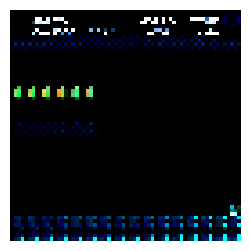

reconstructed image


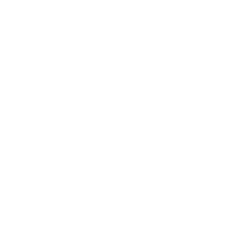

In [73]:
sample_dataset = marioDataset(path_dir='data/mario/',num_frames=1, transform=transform)
sample_image(model, sample_dataset)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6564), started 2 days, 23:44:22 ago. (Use '!kill 6564' to kill it.)

c:\Users\anmol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anmol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Step 1/244, Loss: 2.712007522583008
Epoch 1, Step 11/244, Loss: 2.0832200050354004
Epoch 1, Step 21/244, Loss: 1.8265053033828735
Epoch 1, Step 31/244, Loss: 1.9385706186294556
Epoch 1, Step 41/244, Loss: 1.7082710266113281
Epoch 1, Step 51/244, Loss: 1.5096160173416138
Epoch 1, Step 61/244, Loss: 1.588064432144165
Epoch 1, Step 71/244, Loss: 1.4793654680252075
Epoch 1, Step 81/244, Loss: 1.5995228290557861
Epoch 1, Step 91/244, Loss: 1.5537381172180176
Epoch 1, Step 101/244, Loss: 1.7136292457580566
Epoch 1, Step 111/244, Loss: 1.897452473640442
Epoch 1, Step 121/244, Loss: 1.711723804473877
Epoch 1, Step 131/244, Loss: 1.5808875560760498
Epoch 1, Step 141/244, Loss: 1.7237789630889893
Epoch 1, Step 151/244, Loss: 1.513847827911377
Epoch 1, Step 161/244, Loss: 1.5825599431991577
Epoch 1, Step 171/244, Loss: 1.7293996810913086
Epoch 1, Step 181/244, Loss: 1.7496023178100586
Epoch 1, Step 191/244, Loss: 1.7549148797988892
Epoch 1, Step 201/244, Loss: 1.5238338708877563
Epoch 1,

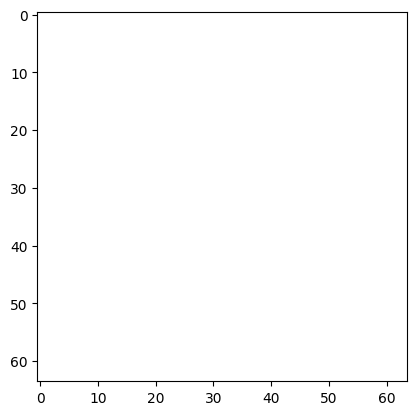

c:\Users\anmol\anaconda3\lib\site-packages\torch\utils\tensorboard\summary.py:574: RuntimeWarning: invalid value encountered in cast
  tensor = (tensor * scale_factor).clip(0, 255).astype(np.uint8)


Model saved at epoch 1
Epoch 2, Step 1/244, Loss: 1.4482073783874512
Epoch 2, Step 11/244, Loss: 1.8168919086456299
Epoch 2, Step 21/244, Loss: 1.4549083709716797
Epoch 2, Step 31/244, Loss: 1.5896458625793457
Epoch 2, Step 41/244, Loss: 1.3727595806121826
Epoch 2, Step 51/244, Loss: 1.5389044284820557
Epoch 2, Step 61/244, Loss: 1.5853750705718994
Epoch 2, Step 71/244, Loss: 1.5785335302352905
Epoch 2, Step 81/244, Loss: 1.6000640392303467
Epoch 2, Step 91/244, Loss: 1.703873634338379
Epoch 2, Step 101/244, Loss: 1.457298755645752
Epoch 2, Step 111/244, Loss: 1.4124259948730469
Epoch 2, Step 121/244, Loss: 1.512451171875
Epoch 2, Step 131/244, Loss: 1.6777440309524536
Epoch 2, Step 141/244, Loss: 1.5363837480545044
Epoch 2, Step 151/244, Loss: 1.376021146774292
Epoch 2, Step 161/244, Loss: 1.4013715982437134
Epoch 2, Step 171/244, Loss: 1.4624831676483154
Epoch 2, Step 181/244, Loss: 1.5735750198364258
Epoch 2, Step 191/244, Loss: 1.4151604175567627
Epoch 2, Step 201/244, Loss: 1.4849

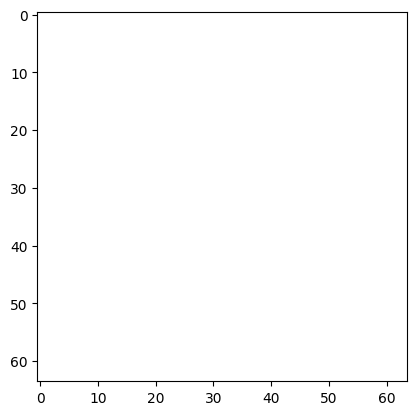

Model saved at epoch 2
Epoch 3, Step 1/244, Loss: 1.421208143234253
Epoch 3, Step 11/244, Loss: 1.33113694190979
Epoch 3, Step 21/244, Loss: 1.3699007034301758
Epoch 3, Step 31/244, Loss: 1.4242067337036133
Epoch 3, Step 41/244, Loss: 1.4545261859893799
Epoch 3, Step 51/244, Loss: 1.4117542505264282
Epoch 3, Step 61/244, Loss: 1.4331307411193848
Epoch 3, Step 71/244, Loss: 1.4279499053955078
Epoch 3, Step 81/244, Loss: 1.3717609643936157
Epoch 3, Step 91/244, Loss: 1.565197229385376
Epoch 3, Step 101/244, Loss: 1.6375114917755127
Epoch 3, Step 111/244, Loss: 1.4864294528961182
Epoch 3, Step 121/244, Loss: 1.48714280128479
Epoch 3, Step 131/244, Loss: 1.67490553855896
Epoch 3, Step 141/244, Loss: 1.5710725784301758
Epoch 3, Step 151/244, Loss: 1.6592872142791748
Epoch 3, Step 161/244, Loss: 1.5309735536575317
Epoch 3, Step 171/244, Loss: 1.3838884830474854
Epoch 3, Step 181/244, Loss: 1.48256254196167
Epoch 3, Step 191/244, Loss: 1.5758839845657349
Epoch 3, Step 201/244, Loss: 1.3332834

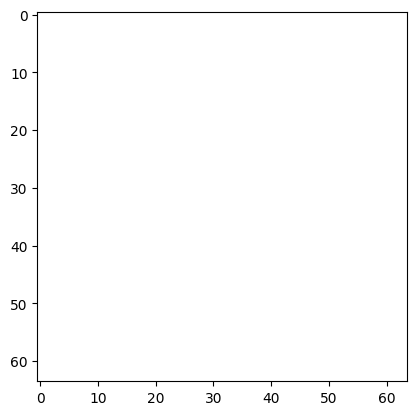

Model saved at epoch 3
Epoch 4, Step 1/244, Loss: 1.6012628078460693
Epoch 4, Step 11/244, Loss: 1.415285587310791
Epoch 4, Step 21/244, Loss: 1.438281774520874
Epoch 4, Step 31/244, Loss: 1.438401460647583
Epoch 4, Step 41/244, Loss: 1.3986282348632812
Epoch 4, Step 51/244, Loss: 1.2985087633132935
Epoch 4, Step 61/244, Loss: 1.488074779510498
Epoch 4, Step 71/244, Loss: 1.4584240913391113
Epoch 4, Step 81/244, Loss: 1.5881115198135376
Epoch 4, Step 91/244, Loss: 1.3222744464874268
Epoch 4, Step 101/244, Loss: 1.4745843410491943
Epoch 4, Step 111/244, Loss: 1.4758954048156738
Epoch 4, Step 121/244, Loss: 1.3583018779754639
Epoch 4, Step 131/244, Loss: 1.5393298864364624
Epoch 4, Step 141/244, Loss: 1.4359503984451294
Epoch 4, Step 151/244, Loss: 1.422898530960083
Epoch 4, Step 161/244, Loss: 1.4224066734313965
Epoch 4, Step 171/244, Loss: 1.638453483581543
Epoch 4, Step 181/244, Loss: 1.2987964153289795
Epoch 4, Step 191/244, Loss: 1.2553694248199463
Epoch 4, Step 201/244, Loss: 1.359

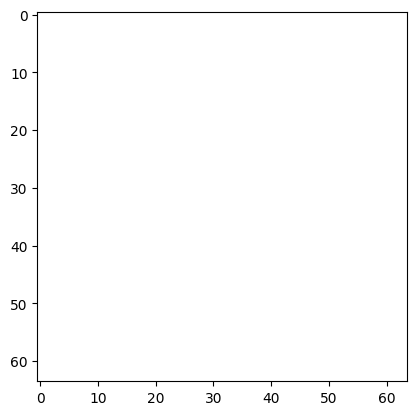

Model saved at epoch 4
Epoch 5, Step 1/244, Loss: 1.4636648893356323
Epoch 5, Step 11/244, Loss: 1.353851556777954
Epoch 5, Step 21/244, Loss: 1.4163928031921387
Epoch 5, Step 31/244, Loss: 1.3839761018753052
Epoch 5, Step 41/244, Loss: 1.478178858757019
Epoch 5, Step 51/244, Loss: 1.599113941192627
Epoch 5, Step 61/244, Loss: 1.3250164985656738
Epoch 5, Step 71/244, Loss: 1.2715972661972046
Epoch 5, Step 81/244, Loss: 1.5877454280853271
Epoch 5, Step 91/244, Loss: 1.344803810119629
Epoch 5, Step 101/244, Loss: 1.3839051723480225
Epoch 5, Step 111/244, Loss: 1.4764766693115234
Epoch 5, Step 121/244, Loss: 1.511641263961792
Epoch 5, Step 131/244, Loss: 1.371205449104309
Epoch 5, Step 141/244, Loss: 1.5062402486801147
Epoch 5, Step 151/244, Loss: 1.4570939540863037
Epoch 5, Step 161/244, Loss: 1.340484380722046
Epoch 5, Step 171/244, Loss: 1.3753244876861572
Epoch 5, Step 181/244, Loss: 1.4795045852661133
Epoch 5, Step 191/244, Loss: 1.4938809871673584
Epoch 5, Step 201/244, Loss: 1.4416

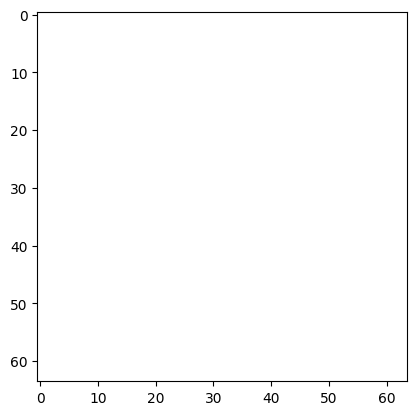

Model saved at epoch 5


In [37]:
# Start TensorBoard
%load_ext tensorboard
%tensorboard --logdir=runs

train_autoencoder(model, start_epoch=0, num_epochs=5)

In [39]:
!kill 6564

kill: 6564: No such process
